# Nonlinear least squares (with two parameters)  
### This code estimates the model $$y_t = \theta_1 x_t^{\theta_2} + \varepsilon_t$$ using a nonlinear least-squares procedure.     

In [1]:
import os
from platform import python_version
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

# The recommended python version is 3.8 or 3.9
print(python_version())
# Check current directory
os.getcwd()


3.8.5


'/Users/Fbandi/Dropbox/nonlineareconometrics2024/FEDERICO/Python_codes'

### We are simulating the data. We will set the parameter values as being equal to $(2,2)$ and both $x_t$ and $e_t$ as being normal with certain means and variances. Given the parameter values, $x_t$ and $e_t$, the model will yield $y_t.$ Of course, all quantities can be easily modified. 

In [2]:
# sample size
sample_size = 1000      # Choose the number of observations - You can increase this number to see if the LLN would work

# population parameters
mean_of_x = 20           # mean of the regressor
variance_of_x = 4        # variance of the regressor
variance_of_e = 1000     # variance of the residual

# The parameter values
theta = [2,2] 

# generate x as a sample from the Normal distribution
x = np.random.normal(mean_of_x, np.sqrt(variance_of_x), sample_size)

# generate the residuals as a sample from the Normal distribution
e = np.random.normal(0, np.sqrt(variance_of_e), sample_size)

# generate y using the formula
y =  theta[0]*(x**theta[1]) + e


### Let us look at the data first. We want to make sure that we have generated enough dispersion (through the variance of the residuals) around the curve. In other words, we do not want all of the observations y and x to exactly sit on a curve. We want the model to be realistic.

Text(0.5, 1.0, 'A scatterplot of the data')

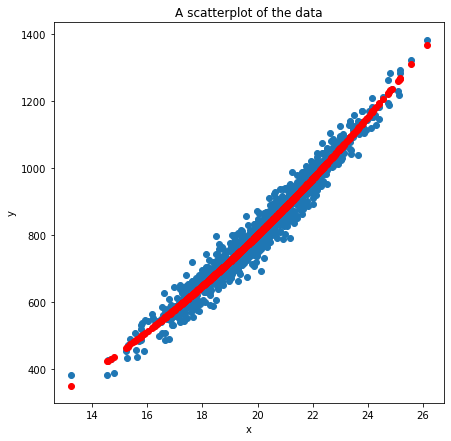

In [3]:
# Adjust the plot size on your computer
plt.rcParams['figure.figsize'] = [7, 7]

# A scatterplot with matplotlib
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x, y) 
plt.scatter(x,theta[0]*(x**theta[1]), color = 'red')
plt.title('A scatterplot of the data')

### Now that we have the data, we are ready to begin. Let us go step by step.

### (1) We define the least-squares criterion in a `Python function` called `nls`. The criterion is:

\begin{eqnarray*}
&&\frac{1}{T} \sum_{t=1}^T \varepsilon_t^2 \\
&=& \frac{1}{T} \sum_{t=1}^T  \left(y_t  - \theta_1 x_t^{\theta_2} \right)^2.\\
\end{eqnarray*}


In [4]:
def nls(parameters, y, x):
    f =  np.mean( (y -  parameters[0]*np.power( x, parameters[1] ))**2  )
    return f

### (2) We now minimize the function with respect to $\theta_1$ and $\theta_2:$

\begin{eqnarray*}
(\widehat{\theta}_1, \widehat{\theta}_2) &=& \arg\min_{\theta_1,\theta_2}  \frac{1}{T} \sum_{t=1}^T \varepsilon_t^2 \\
&=&  \arg\min_{\theta_1,\theta_2} \frac{1}{T} \sum_{t=1}^T  \left(y_t  - \theta_1 x_t^{\theta_2} \right)^2\\
\end{eqnarray*}

### In order to do so we have to feed the function into a minimizer: another function which will compute the minimum of the criterion. A possible function is `scipy.optimize.fmin`. 

The inputs of the `scipy.optimize.fmin` function are:

1. `func`. The function to minimize - in our case `nls` - as defined in the previous snippet.
2. `x0`. The initial guess of the parameters $\theta_1$ and $\theta_2$: `initial_guess`. This is just our initial guess of the parameters for evaluating the function `nls` at the beginning of the minimization.
3. `args`. The arguments of the `nls` function that are not paramaters. For our problem, these are the data $y_t,x_t$ with $t=1,\cdots, T$, contained in `y` and `x`, respectively.

Additional inputs that are optional:

4. `xtol` and `ftol`. This is the tolerance for the minimizer and the function evaluation, respectively. The algorithm will stop automatically when it cannot find another minimizer that is smaller by at least `xtol` than the current one. Same as for the function evaluation. 
5. `maxiter`. The maximum number of iterations to try. The algorithm stops if it reaches `maxiter` attempts, even if it did not find a minimum.
6. `disp`. A variable indicating whether we want to see some results or not. `disp=0` will not show results, `disp=1` will provide additional information.


In [5]:
initial_guess = [1,-1]
estimates = scipy.optimize.fmin(func=nls, 
                                x0=initial_guess, 
                                args=(y, x), 
                                xtol=1e-5, 
                                ftol=1e-5, 
                                maxiter = 1000000, 
                                disp=0
                                )

print(f'The estimates are {estimates[0]:.3f} and {estimates[1]:.3f}')

The estimates are 1.980 and 2.003



### Inference in Nonlinear Least Squares

If we want to do inference we need to compute the variance-covariance matrix of $\widehat{\theta}_{NL}$, which has the following form: $$\mathbb{V}(\widehat{\theta}_{NL}) = \frac{1}{T} A_0^{-1} \Omega_0 A_0^{-1},$$ where $$ \Omega_0 = \mathbb{E}\left(\varepsilon_t^2 \frac{\partial f(x_t,\theta_0)}{\partial \theta} \frac{\partial f(x_t,\theta_0)}{\partial \theta^\top} \right) $$ and
$$ A_0 =  \mathbb{E}\left( \frac{\partial f(x_t,\theta_0)}{\partial \theta} \frac{\partial f(x_t,\theta_0)}{\partial \theta^\top} \right). $$

**Notice that we are dividing by $\frac{1}{T}$. By the CLT, in fact, $A_0^{-1} \Omega_0 A_0^{-1}$ is the variance-covariance matrix of $\sqrt{T}\widehat{\theta}_{NL}$. Because we want the variance-covariance matrix of $\widehat{\theta}_{NL}$, we need to divide by $T$.** 

All we need to do is compute the derivatives (which can be done manually) and then calculate sample analogues to the expectations. These sample analogues are just empirical means. The empirical means will be consistent for the corresponding expectations by the LLN.

The derivatives are $$ \frac{\partial f(x_t,\theta_1,\theta_2)}{\partial \theta} = \begin{bmatrix}\frac{\partial f(x_t,\theta_1,\theta_2)}{\partial \theta_1}  \\ \frac{\partial f(x_t,\theta_1,\theta_2)}{\partial \theta_2}  \end{bmatrix} = \begin{bmatrix}  x_t^{\theta_2}  \\ \theta_1 x_t^{\theta_2}\log(x_t) \end{bmatrix}.$$

Thus, we have:

\begin{equation*}
\widehat{\Omega}_0 = \frac{1}{T}\sum_{t=1}^T \widehat{\varepsilon}_t^2 \frac{\partial f(x_t,\widehat{\theta}_{NL})}{\partial \theta} \frac{\partial f(x_t,\widehat{\theta}_{NL})}{\partial \theta^\top} = \frac{1}{T}\sum_{t=1}^T \widehat{\varepsilon}_t^2 \underbrace{\begin{bmatrix}  x_t^{\widehat{\theta}_2}  \\ \widehat{\theta}_1 x_t^{\widehat{\theta}_2}\log(x_t) \end{bmatrix} \begin{bmatrix}  x_t^{\widehat{\theta}_2} & \widehat{\theta}_1 x_t^{\widehat{\theta}_2}\log(x_t) \end{bmatrix}}_{\textrm{outer product}} = \frac{1}{T}\sum_{t=1}^T \widehat{\varepsilon}_t^2 \begin{bmatrix}  x_t^{2\widehat{\theta}_2}  & \widehat{\theta}_1 x_t^{2\widehat{\theta}_2}\log(x_t) \\ \widehat{\theta}_1 x_t^{2\widehat{\theta}_2}\log(x_t) & \widehat{\theta}^2_1 x_t^{2\widehat{\theta}_2}\log^2(x_t) \end{bmatrix},
\end{equation*}
and
\begin{equation*}
\widehat{A}_0 = \frac{1}{T}\sum_{t=1}^T \underbrace{\begin{bmatrix}  x_t^{\widehat{\theta}_2}  \\ \widehat{\theta}_1 x_t^{\widehat{\theta}_2}\log(x_t) \end{bmatrix} \begin{bmatrix}  x_t^{\widehat{\theta}_2} & \widehat{\theta}_1 x_t^{\widehat{\theta}_2}\log(x_t) \end{bmatrix}}_{\textrm{outer product}} = \frac{1}{T}\sum_{t=1}^T \begin{bmatrix}  x_t^{2\widehat{\theta}_2}  & \widehat{\theta}_1 x_t^{2\widehat{\theta}_2}\log(x_t) \\ \widehat{\theta}_1 x_t^{2\widehat{\theta}_2}\log(x_t) & \widehat{\theta}^2_1 x_t^{2\widehat{\theta}_2}\log^2(x_t) \end{bmatrix}.
\end{equation*}

### We begin with $\widehat{A}_0$. `We will compute the outer product of the gradient (as above) - for each t - and then average the outer products from the first one to the last one`.

In [6]:
#This command creates the gradient (for all times t)
deriv = np.array([ x**estimates[1] ,  estimates[0]*(x**estimates[1])*np.log(x) ])  

# This is the loop which averages the outer products, from the first time to the last one, 
# and puts them into a 2 times 2 array A_hat. 
A_hat = np.zeros((2,2))
for t in range(sample_size):                                                                               
        A_hat = A_hat + np.outer(deriv[:,t],deriv[:,t].T)/sample_size
        # A_hat += np.outer(deriv[:,t],deriv[:,t].T)/sample_size       #This is a fancier Python way write the loop
        
# Now, we need to invert A_hat        
invA_hat = np.linalg.inv(A_hat)        

### We now turn to $\widehat{\Omega}_0$. `We will compute the outer product of the gradient times the squared errors - for each t - and then average these quantities from the first one to the last one`.

In [7]:
#This is the loop which averages the outer products times the squared errors, from the first time to the last one, and puts them into a 2 times 2 array A_hat. 
Omega_hat = np.zeros((2,2))
for t in range(sample_size):
        Omega_hat += ((y[t]-estimates[0]*(x[t]**estimates[1]))**2)*np.outer(deriv[:,t] , deriv[:,t].T)/sample_size    

### Finally, we compute $\mathbb{V}(\widehat{\theta}_{NL})$

In [8]:
#Now, we can compute the variance-covariance matrix of the estimates
VarCov = (1/sample_size)*invA_hat @ Omega_hat @ invA_hat

#The standard errors of the estimates are the square roots of the diagonal elements of VarCov 
S_errors = np.sqrt(np.diag(VarCov))

#Given estimates and standar errors, we can compute t-statistics as the ratio between the two
t_stats = estimates/S_errors

print(f'The t-statistic of the first parameter estimate is {t_stats[0]:.3f}')
print(f'The t-statistic of the second parameter estimate is {t_stats[1]:.3f}')

The t-statistic of the first parameter estimate is 25.837
The t-statistic of the second parameter estimate is 156.968
